In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'




ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:'2019-01-01']
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


for ticker in ticker_list:
    data_dated = data_dated.append(stock_data(ticker), sort=False)


<ipython-input-4-50d4edb1b606>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [5]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2131, 9)


In [6]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [7]:
data_dated.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
2021-02-10,74.60,74.865,73.5500,74.33,74.33,7180859.0,0.0,1.0,MS
2021-02-09,73.90,74.680,73.3700,74.24,74.24,7323686.0,0.0,1.0,MS
2021-02-08,73.64,74.290,73.4000,74.23,74.23,9018095.0,0.0,1.0,MS
2021-02-05,73.10,73.715,72.5503,73.22,73.22,8832176.0,0.0,1.0,MS
2021-02-04,70.93,72.320,70.7670,72.29,72.29,8889354.0,0.0,1.0,MS


In [8]:


%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

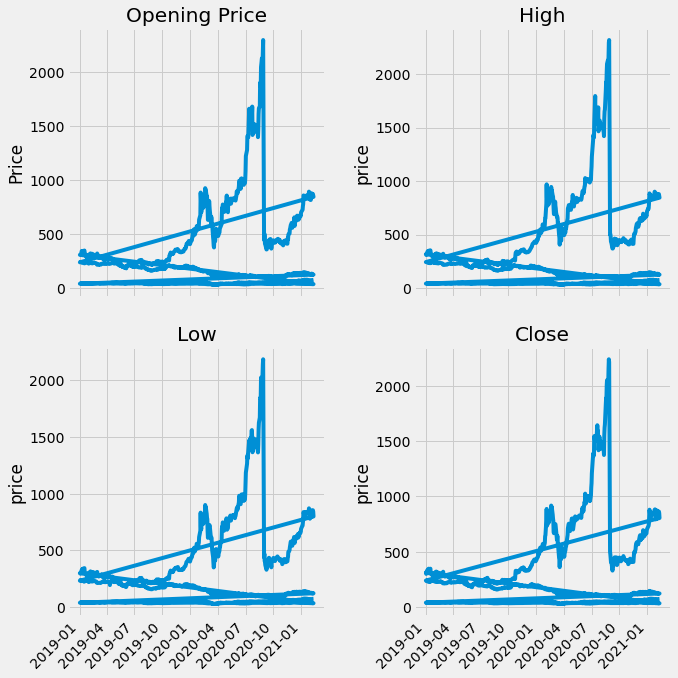

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [10]:
data_dated[data_dated.duplicated()]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker


One Hot Encoding 

# data_dated.tail()

In [11]:
data_dated['date']= data_dated.index

In [12]:
data_dated.sort_index(inplace=True)
data_dated.sort_values(by = ['Ticker','date'], inplace = True)


data_dated['change_in_price']= data_dated['4. close'].diff()

In [13]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price
2019-01-02,237.00,242.20,233.25,240.00,220.802700,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN
2019-01-02,39.02,40.72,38.76,40.40,37.935801,10648013.0,0.0,1.0,MS,2019-01-02,NaN
2019-01-02,43.12,43.50,42.64,43.25,37.587547,25076212.0,0.0,1.0,PFE,2019-01-02,NaN
2019-01-02,306.10,315.13,298.80,310.12,62.024000,11658600.0,0.0,1.0,TSLA,2019-01-02,NaN


In [14]:
data_dated['day'] = data_dated.index.day
data_dated['month'] = data_dated.index.month
data_dated['year'] = data_dated.index.year

In [15]:
data_dated.head(10)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price,day,month,year
2019-01-02,237.00,242.20,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN,2,1,2019
2019-01-03,240.10,242.60,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,2019-01-03,0.10,3,1,2019
2019-01-04,241.00,241.90,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,2019-01-04,-2.75,4,1,2019
2019-01-07,239.95,242.00,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,2019-01-07,0.60,7,1,2019
2019-01-08,237.75,238.90,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,2019-01-08,-6.95,8,1,2019
2019-01-09,232.30,234.85,230.550,232.50,213.9026,25148123.0,0.0,1.0,BT-A.L,2019-01-09,1.50,9,1,2019
2019-01-10,232.70,234.70,231.850,233.55,214.8686,17643904.0,0.0,1.0,BT-A.L,2019-01-10,1.05,10,1,2019
2019-01-11,233.75,236.35,232.500,233.05,214.4086,46248643.0,0.0,1.0,BT-A.L,2019-01-11,-0.50,11,1,2019
2019-01-14,232.85,233.15,228.050,228.60,210.3146,50697635.0,0.0,1.0,BT-A.L,2019-01-14,-4.45,14,1,2019
2019-01-15,231.65,232.25,229.100,229.95,211.5566,17775775.0,0.0,1.0,BT-A.L,2019-01-15,1.35,15,1,2019


In [16]:
data_dated.reset_index(inplace=True)

In [17]:
days_out= 90

data_dated_smoothed = data_dated.groupby(['Ticker'])[['1. open','2. high','3. low','4. close','6. volume','day', 'month', 'year']].transform(lambda x: x.ewm(span = days_out).mean())

smoothed_df = pd.concat([data_dated[['Ticker','date']], data_dated_smoothed], axis=1, sort=False)

In [18]:
# define the number of days out you want to predict
days_out = 90

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,Signal_Flag
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.000000,2019.0,NaN
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.000000,2019.0,NaN
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.000000,2019.0,NaN
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.000000,2019.0,NaN
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.000000,2019.0,NaN
5,BT-A.L,2019-01-09,237.956651,240.319055,233.974070,236.364211,2.026728e+07,5.598120,1.000000,2019.0,NaN
6,BT-A.L,2019-01-10,237.154721,239.461839,233.650032,235.934889,1.986707e+07,6.269650,1.000000,2019.0,NaN
7,BT-A.L,2019-01-11,236.695302,239.041940,233.494851,235.545614,2.342689e+07,6.907943,1.000000,2019.0,NaN
8,BT-A.L,2019-01-14,236.229095,238.327598,232.834714,234.703523,2.673321e+07,7.767789,1.000000,2019.0,NaN
9,BT-A.L,2019-01-15,235.724054,237.657283,232.422802,234.179244,2.574527e+07,8.565449,1.000000,2019.0,NaN


In [19]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = smoothed_df[['Ticker','Signal_Flag']].copy(), smoothed_df[['Ticker','Signal_Flag']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['Signal_Flag'] = up_df.loc[(up_df['Signal_Flag'] < 0), 'Signal_Flag'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['Signal_Flag'] = down_df.loc[(down_df['Signal_Flag'] > 0), 'Signal_Flag'] = 0

# We need change in price to be absolute.
down_df['Signal_Flag'] = down_df['Signal_Flag'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['Signal_Flag'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['Signal_Flag'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
smoothed_df['down_days'] = down_df['Signal_Flag']
smoothed_df['up_days'] = up_df['Signal_Flag']
smoothed_df['RSI'] = relative_strength_index

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,Signal_Flag,down_days,up_days,RSI
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.0,2019.0,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.0,2019.0,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.0,2019.0,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.0,2019.0,NaN,NaN,NaN,NaN


In [20]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((smoothed_df['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
smoothed_df['low_14'] = low_14
smoothed_df['high_14'] = high_14
smoothed_df['k_percent'] = k_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - smoothed_df['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
smoothed_df['r_percent'] = r_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Calculate the MACD
ema_26 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
smoothed_df['MACD'] = macd
smoothed_df['MACD_EMA'] = ema_9_macd

# Print the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001134,0.000630
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027092,-0.010731
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050277,-0.024128
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.0,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126893,-0.054698


In [23]:

# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
smoothed_df['Price_Rate_Of_Change'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001134,0.000630,NaN
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027092,-0.010731,NaN
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050277,-0.024128,NaN
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.0,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126893,-0.054698,NaN


In [24]:
def obv(group):

    # Grab the volume and close column.
    volume = group['6. volume']
    change = group['4. close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = smoothed_df.groupby('Ticker').apply(obv)

# add to the data frame, but drop the old index, before adding it.
smoothed_df['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
smoothed_df.head(30)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00
1,BT-A.L,2019-01-03,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001134,0.000630,NaN,1.709174e+07
2,BT-A.L,2019-01-04,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.027092,-0.010731,NaN,-8.152300e+05
3,BT-A.L,2019-01-07,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.050277,-0.024128,NaN,-1.810220e+07
4,BT-A.L,2019-01-08,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.126893,-0.054698,NaN,-3.732653e+07
5,BT-A.L,2019-01-09,237.956651,240.319055,233.974070,236.364211,2.026728e+07,5.598120,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.205872,-0.095675,NaN,-5.759381e+07
6,BT-A.L,2019-01-10,237.154721,239.461839,233.650032,235.934889,1.986707e+07,6.269650,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.272425,-0.140406,NaN,-7.746088e+07
7,BT-A.L,2019-01-11,236.695302,239.041940,233.494851,235.545614,2.342689e+07,6.907943,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.331185,-0.186253,NaN,-1.008878e+08
8,BT-A.L,2019-01-14,236.229095,238.327598,232.834714,234.703523,2.673321e+07,7.767789,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.408615,-0.237620,NaN,-1.276210e+08
9,BT-A.L,2019-01-15,235.724054,237.657283,232.422802,234.179244,2.574527e+07,8.565449,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.484602,-0.292958,-0.024253,-1.533662e+08


In [25]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = smoothed_df.groupby('Ticker')['4. close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
smoothed_df['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
smoothed_df.loc[smoothed_df['Prediction'] == 0.0] = 1.0

# print the head
smoothed_df.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,BT-A.L,2019-01-02 00:00:00,237.000000,242.200000,233.250000,240.000000,2.027842e+07,2.000000,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN
1,BT-A.L,2019-01-03 00:00:00,238.567222,242.402222,235.423889,240.050556,1.709174e+07,2.505556,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,0.001134,0.000630,NaN,1.709174e+07,1.0
2,BT-A.L,2019-01-04 00:00:00,239.396235,242.231081,235.773555,239.130293,1.790697e+07,3.014814,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.027092,-0.010731,NaN,-8.152300e+05,-1.0
3,BT-A.L,2019-01-07 00:00:00,239.539325,242.171371,236.107515,238.825312,1.728697e+07,4.044564,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.050277,-0.024128,NaN,-1.810220e+07,-1.0
4,BT-A.L,2019-01-08 00:00:00,239.165380,241.487699,234.705735,237.189927,1.922433e+07,4.871197,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.126893,-0.054698,NaN,-3.732653e+07,-1.0
5,BT-A.L,2019-01-09 00:00:00,237.956651,240.319055,233.974070,236.364211,2.026728e+07,5.598120,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.205872,-0.095675,NaN,-5.759381e+07,-1.0
6,BT-A.L,2019-01-10 00:00:00,237.154721,239.461839,233.650032,235.934889,1.986707e+07,6.269650,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.272425,-0.140406,NaN,-7.746088e+07,-1.0
7,BT-A.L,2019-01-11 00:00:00,236.695302,239.041940,233.494851,235.545614,2.342689e+07,6.907943,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.331185,-0.186253,NaN,-1.008878e+08,-1.0
8,BT-A.L,2019-01-14 00:00:00,236.229095,238.327598,232.834714,234.703523,2.673321e+07,7.767789,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.408615,-0.237620,NaN,-1.276210e+08,-1.0
9,BT-A.L,2019-01-15 00:00:00,235.724054,237.657283,232.422802,234.179244,2.574527e+07,8.565449,1.000000,2019.0,...,NaN,NaN,NaN,NaN,NaN,-0.484602,-0.292958,-0.024253,-1.533662e+08,-1.0


In [26]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Any row that has a `NaN` value will be dropped.
smoothed_df = smoothed_df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Print the head.
smoothed_df.head()

Before NaN Drop we have 2131 rows and 23 columns
After NaN Drop we have 1771 rows and 23 columns


,Ticker,date,1. open,2. high,3. low,4. close,6. volume,day,month,year,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
90,BT-A.L,2019-05-13 00:00:00,225.508125,227.518962,222.605482,224.888527,1.932276e+07,14.534629,3.390093,2019.0,...,0.0,222.605482,228.538923,38.477591,-61.522409,-0.322923,-0.285028,-0.006354,-9.167353e+08,-1.0
91,BT-A.L,2019-05-14 00:00:00,224.982805,227.086792,222.134508,224.429341,1.936870e+07,14.521132,3.430737,2019.0,...,0.0,222.134508,228.538923,35.832060,-64.167940,-0.416801,-0.311383,-0.008694,-9.361040e+08,-1.0
92,BT-A.L,2019-05-15 00:00:00,224.524001,226.575972,221.683210,223.945461,1.952837e+07,14.533182,3.470225,2019.0,...,0.0,221.683210,228.538923,32.998044,-67.001956,-0.524173,-0.353941,-0.011127,-9.556323e+08,-1.0
93,BT-A.L,2019-05-16 00:00:00,224.038029,226.061104,221.225853,223.467730,1.953954e+07,14.569975,3.508598,2019.0,...,0.0,221.225853,228.538923,30.655756,-69.344244,-0.640406,-0.411234,-0.013156,-9.751719e+08,-1.0
94,BT-A.L,2019-05-17 00:00:00,223.514451,225.510693,220.701329,222.949660,1.979615e+07,14.630741,3.545892,2019.0,...,0.0,220.701329,228.538923,28.686502,-71.313498,-0.765473,-0.482082,-0.015450,-9.949680e+08,-1.0


In [27]:
# Grab our X & Y Columns.
X_Cols = smoothed_df[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = smoothed_df['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [28]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  93.45372460496614
